<a href="https://colab.research.google.com/github/yacinebrg/Brain-MRI-Segmentation-Uncertainty/blob/main/Final_Work_LRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of Cerebral Tissues in Human Brain MRIs with Uncertainty Quantification

This notebook walks through a complete pipeline to train, evaluate and quantify uncertainty in a convolutional neural network for segmenting neonatal brain MRI scans.

**Objectives:**
1. **Load & preprocess** the iSEG-2017 dataset (T1- and T2-weighted MRIs).  
2. **Visualize** sample slices and split data into training, validation and test sets.  
3. **Define and train** a U-Net model for binary segmentation of white and gray matter.  
4. **Implement Monte Carlo Dropout** and **Deep Ensembles** to generate multiple stochastic predictions.  
5. **Compute uncertainty metrics**—Variation Ratio (epistemic) and Predictive Entropy (aleatoric)—and visualize uncertainty maps.  
6. **Compare** MCD, DE, and a hybrid approach on clean and noisy inputs to highlight their behavior in ambiguous regions.



In [1]:
# Core Libraries
import os
import numpy as np
import pandas as pd

# Image Processing Libraries
import PIL
from PIL import Image
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import nibabel as nib  # For working with medical images (NIfTI format)

# Data Visualization Libraries
import seaborn as sns

# TensorFlow and Keras Libraries for Neural Networks
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, concatenate, UpSampling2D, Dropout
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as keras
from keras.models import load_model


In [2]:
# Function to display multiple images in a grid
def fast_display(*images):
    plt.figure(figsize=(16,8))
    nbimg = len(images)
    cols = min(9, nbimg)  # Limit number of columns to 9
    rows = (nbimg // cols) + 1  # Calculate required number of rows
    for ii, img in enumerate(images):
        plt.subplot(rows, cols, 1 + ii)  # Display each image in the grid
        plt.imshow(img)
        plt.axis('off')  # Turn off the axis for a cleaner display
    plt.show()

# Function to display a patient by their index in the data list
def afficher_patient_index(data, i, normaliser=False):
    afficher_patient(data[i-1], normaliser)

# Function to display all patients in the dataset
def display_data(data, normaliser=False):
    for patient in data:
        afficher_patient(patient, normaliser)

# Function to split the data into smaller subsets
def decoupe_data(img):
    res = []
    for elm, _, names in img:
        sorted_names = sorted(names)  # Sort image names for consistent processing
        for i in range(0, len(names), 6):  # Group images into sets of 6
            res.append(sorted_names[i:i+6])
    return res

# Function to separate the data into specific subsets
def separation_data(data):
    return data[0:6], data[6:8], data[8:]  # Return three slices of the data

# Function to apply Gaussian normalization on an image
def normalisation_Gaussienne(image):
    return (image - np.mean(image)) / np.std(image)  # Normalize by subtracting mean and dividing by standard deviation


### Data Loading and Splitting

In this section, we load the iSeg-2017 training dataset from the specified directory and split the images into smaller subsets for each patient using the `decoupe_data()` function. The dataset is then divided into three groups: training, validation, and testing using the `separation_data()` function. Finally, we print the number of patients in each subset.


In [4]:
# Set the directory path to the iSeg-2017 training dataset
iSeg = '/content/drive/MyDrive/LRDE PROJET CERVEAU/iSeg-2017-Training'

# Change the current working directory to the specified iSeg path
os.chdir(iSeg)

# Traverse the directory and gather all images
images = os.walk(iSeg)

# Split the images data into smaller subsets for each patient
patients = np.array(decoupe_data(images))
print("Number of patients: ", len(patients))

# Split the patients into three categories: training, validation, and testing
trainings = []
validations = []
tests = []
trainings, validations, tests = separation_data(patients)

# Print the number of patients in each category
print("Number of patients for training: ", len(trainings))
print("Number of patients for validation: ", len(validations))
print("Number of patients for testing: ", len(tests))

Number of patients:  10
Number of patients for training:  6
Number of patients for validation:  2
Number of patients for testing:  2


In [6]:
# Split the patients into three categories: training, validation, and testing
trainings = []
validations = []
tests = []
trainings, validations, tests = separation_data(patients)

# Print the number of patients in each category
print("Number of patients for training: ", len(trainings))
print("Number of patients for validation: ", len(validations))
print("Number of patients for testing: ", len(tests))

# Function to count relevant slices and their dimensions
def compter_coupes_pertinentes_et_dimensions(patients):
    n_pertinentes = 0  # Number of relevant slices
    total_coupes = 0  # Total number of slices
    L = []  # List to store image dimensions

    for patient in patients:
        # Find the corresponding label image
        label = next(p for p in patient if 'label' in p and p.endswith('.img'))
        lab = nib.load(label).get_fdata()  # Load the label image
        sx, sy, sz, _ = lab.shape  # Get the dimensions of the label image

        # Save the dimensions
        L = (sx, sy)

        # Count the total number of slices and relevant slices
        for z in range(sz):
            total_coupes += 1  # Increment total slice count
            coupe = lab[:,:,z]  # Extract the slice
            aire = np.sum(coupe > 0)  # Calculate the area of relevant regions
            if aire > 100:  # If the area is significant, count it as relevant
                n_pertinentes += 1

    return n_pertinentes, total_coupes, L[0], L[1]

# Call the function for each group of patients
nb_coupes_entrainements, total_entrainements, sx, sy = compter_coupes_pertinentes_et_dimensions(trainings)
nb_coupes_validations, total_validations, _, _ = compter_coupes_pertinentes_et_dimensions(validations)
nb_coupes_tests, total_tests, _, _ = compter_coupes_pertinentes_et_dimensions(tests)

# Print the results
print("Number of relevant slices for training patients: ", nb_coupes_entrainements, "/", total_entrainements)
print("Number of relevant slices for validation patients: ", nb_coupes_validations, "/", total_validations)
print("Number of relevant slices for testing patients: ", nb_coupes_tests, "/", total_tests)

# Print the number of discarded slices
print("\nDiscarded slices for training patients: ", total_entrainements - nb_coupes_entrainements)
print("Discarded slices for validation patients: ", total_validations - nb_coupes_validations)
print("Discarded slices for testing patients: ", total_tests - nb_coupes_tests)

Number of patients for training:  6
Number of patients for validation:  2
Number of patients for testing:  2

Number of relevant slices for training patients:  596 / 1536
Number of relevant slices for validation patients:  198 / 512
Number of relevant slices for testing patients:  200 / 512

Discarded slices for training patients:  940
Discarded slices for validation patients:  314
Discarded slices for testing patients:  312


In [8]:
# Function to prepare training data with T1, T2 images and ground truth labels
def training_data_MG_MB(n_coupes, x, y, data):
    numero_coupe = 0  # Initialize slice counter

    for patient in data:
        # Filter files with the '.hdr' extension
        images_patient = [p for p in patient if not p.endswith('.hdr')]

        # Load the label and T1, T2 sequences
        label = nib.load(images_patient[2]).get_fdata()  # 3D or 4D label
        T1_normalized = normalisation_Gaussienne(nib.load(images_patient[0]).get_fdata())  # Normalized T1
        T2_normalized = normalisation_Gaussienne(nib.load(images_patient[1]).get_fdata())  # Normalized T2

        # Calculate the VT150 volumes from the labels
        #VT10 = np.where(label >= 10, 1, 0)   # Volume for values >= 10
        VT150 = np.where(label >= 150, 1, 0)  # Volume for values >= 150

        # Retrieve the dimensions of the volume
        sx, sy, sz, _ = label.shape

        # Loop through slices along the z-axis
        for z in range(sz):
            groundtruths = VT150[:, :, z]  # 2D slice of label at z
            aire = np.sum(groundtruths > 0)  # Calculate the area of relevant pixels

            # If the area is greater than 100, consider the slice relevant
            if aire > 100:
                # Store data in x (input) and y (label)
                x[numero_coupe, :, :, 0] = np.squeeze(T1_normalized[:, :, z])  # T1 slice in 2D
                x[numero_coupe, :, :, 1] = np.squeeze(T2_normalized[:, :, z])  # T2 slice in 2D
                #x[numero_coupe, :, :, 2] = np.squeeze(VT10[:, :, z])  # VT10 slice in 2D

                # Store the labels in y
                y[numero_coupe, :, :] = np.squeeze(groundtruths)  # Corresponding label

                # Increment slice counter
                numero_coupe += 1
    return x, y

# Function to initialize the data arrays for the input (x) and label (y)
def init_data_arrays(nb_coupes, sx, sy):
    x_data = np.zeros((nb_coupes, sx, sy, 2))  # 3 channels (T1, T2)
    y_data = np.zeros((nb_coupes, sx, sy))  # 1 channel for the label
    return x_data, y_data

In [9]:
# Initialize arrays for training, validation, and test data
x_train, y_train = init_data_arrays(nb_coupes_entrainements, sx, sy)
x_val, y_val = init_data_arrays(nb_coupes_validations, sx, sy)
x_test, y_test = init_data_arrays(nb_coupes_tests, sx, sy)

# Fill the data arrays using the preparation function
training_data_MG_MB(nb_coupes_entrainements, x_train, y_train, trainings)
training_data_MG_MB(nb_coupes_validations, x_val, y_val, validations)
training_data_MG_MB(nb_coupes_tests, x_test, y_test, tests)

# Display the shapes of the arrays
print("x_train.shape : ", x_train.shape)
print("y_train.shape : ", y_train.shape)
print("x_val.shape : ", x_val.shape)
print("y_val.shape : ", y_val.shape)
print("x_test.shape : ", x_test.shape)
print("y_test.shape : ", y_test.shape)

x_train.shape :  (596, 144, 192, 2)
y_train.shape :  (596, 144, 192)
x_val.shape :  (198, 144, 192, 2)
y_val.shape :  (198, 144, 192)
x_test.shape :  (200, 144, 192, 2)
y_test.shape :  (200, 144, 192)


### U-Net Model Architecture

This code defines a **U-Net** architecture, which is widely used for image segmentation tasks, especially in medical imaging. It consists of an encoder-decoder structure with skip connections between corresponding layers of the encoder and decoder.

1. **Encoder (Contracting Path)**:
   - The model starts with a series of convolutional layers followed by max-pooling.
   - Each block has two convolutional layers with **ReLU** activation and **'he_normal'** kernel initialization.
   - The number of filters doubles with each block (from 64 to 1024), capturing increasingly complex features.
   - **Dropout** layers are used to prevent overfitting, particularly after the deepest convolutional layers.

2. **Bottleneck**:
   - After the encoder, a bottleneck layer with **1024 filters** is created using two convolutional layers and **Dropout** for regularization.
   - This serves as the deepest part of the network, where the most abstract features are learned.

3. **Decoder (Expansive Path)**:
   - The decoder mirrors the encoder, but instead of pooling, it uses **UpSampling** followed by convolutional layers to progressively reconstruct the spatial resolution of the input.
   - Each decoder block uses **concatenate** to combine features from the corresponding encoder block via skip connections.
   - This helps the model to retain high-resolution features that would otherwise be lost in the pooling layers.

4. **Final Layer**:
   - The output layer consists of a **1x1 convolution** that maps the final features to a single-channel output with **sigmoid activation**, making it suitable for binary segmentation tasks.

5. **Compilation**:
   - The model is compiled with the **Adam** optimizer and **binary cross-entropy** loss, making it appropriate for binary segmentation tasks.
   - The model will be trained to minimize this loss while tracking **accuracy** as a performance metric.

6. **Pretrained Weights**:
   - Optionally, the model can load pretrained weights if provided, which allows fine-tuning on new data instead of training from scratch.

---

### Helper Function - `arrays_are_equal`

This simple helper function checks if two arrays are identical by comparing them element-wise using `np.array_equal()`. It returns `True` if the arrays have the same shape and values, and `False` otherwise.


In [10]:
nbf64 = 8
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet(pretrained_weights = None,input_size = (sx,sy,2)):
  inputs = Input(input_size)
  conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(nbf512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(nbf256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(nbf128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(nbf64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model


def arrays_are_equal(arr1, arr2):
    return np.array_equal(arr1, arr2)

### Model Initialization and Loading

1. **Model Initialization**:
   - The **U-Net** model is initialized by calling the `unet` function with the specified input size `(sx, sy, 2)`. This input size corresponds to the dimensions of the T1 and T2 MRI slices (2 channels).

2. **Model Path**:
   - The path to the pretrained U-Net model is defined as `model_path`, pointing to a `.keras` file located in the specified directory.

3. **Loading the Model**:
   - The model is loaded using `load_model(model_path)`, which loads the trained weights and model architecture from the specified file. This allows the model to be used for inference or further fine-tuning without needing to be trained from scratch.


In [11]:
model_segmentation_MBMG = unet(input_size=(sx, sy, 2))
model_path = "/content/drive/MyDrive/LRDE PROJET CERVEAU/iSeg_V2/models/model_segmentations.keras"

# Model Loading
model_segmentation_MBMG = load_model(model_path)

In [12]:
# Display the number of layers in the model
print(f"Number of layers in the model: {len(model_segmentation_MBMG.layers)}")

# Display the total number of parameters in the model
print(f"Total number of parameters in the model: {model_segmentation_MBMG.count_params()}")

Number of layers in the model: 39
Total number of parameters in the model: 485885


In [32]:
def extract_roi_fixed(image):
    x, y, w, h = 25, 10, 150, 120  # Fixed ROI coordinates
    return image[y:y+h, x:x+w]

def load_images(data_list, slice_idx, is_test=True, add_noise=False, noise_mean=0, noise_std=0.05):
    """Loads and prepares the T1, T2 images and the ground truth for a given dataset (test or training),
    with the option to add Gaussian noise.

    Args:
    - data_list: List of paths to the data (training or test).
    - slice_idx: Index of the slice to select.
    - is_test: Boolean, if True, use the test dataset; otherwise use the training dataset.
    - add_noise: Boolean, whether to add Gaussian noise to the input data.
    - noise_mean: Mean of the Gaussian noise.
    - noise_std: Standard deviation of the Gaussian noise.

    Returns:
    - input_data: Input data with T1 and T2 images.
    - groundtruth_2D: Original ground truth (before binarization).
    - groundtruth_2D_binarise: Binarized ground truth.
    - sx, sy: Dimensions of the selected slice.
    """
    img = data_list[0]  # Taking the first image (adjust if necessary)
    img = [i for i in img if not i.endswith('.hdr')]

    # Load the T1 and T2 images, then normalize
    T1_normalized = normalisation_Gaussienne(nib.load(img[0]).get_fdata())
    T2_normalized = normalisation_Gaussienne(nib.load(img[1]).get_fdata())

    # Load the ground truth (truth data)
    groundtruth = nib.load(img[2]).get_fdata()
    sx, sy, sz, _ = groundtruth.shape  # Retrieve the dimensions

    # Select the slice given by slice_idx
    groundtruth_2D = groundtruth[:, :, slice_idx, 0]
    groundtruth_2D_binarise = np.where(groundtruth_2D > 10, 1, 0)

    # Prepare input data for the model
    input_data = np.zeros((1, sx, sy, 2))
    T1_slice = T1_normalized[:, :, slice_idx, 0]
    T2_slice = T2_normalized[:, :, slice_idx, 0]

    # Add noise if the option is enabled
    if add_noise:
        T1_slice = T1_slice + np.random.normal(noise_mean, noise_std, T1_slice.shape)
        T2_slice = T2_slice + np.random.normal(noise_mean, noise_std, T2_slice.shape)

    input_data[0, :, :, 0] = T1_slice
    input_data[0, :, :, 1] = T2_slice

    return input_data, groundtruth_2D, groundtruth_2D_binarise, sx, sy

In [14]:
def monte_carlo_predictions(model, X, n_predictions=30):
    predictions = []
    for _ in range(n_predictions):
        prediction = model(X, training=True)
        predictions.append(extract_roi_fixed(prediction.numpy().reshape(sx, sy)))
    return np.array(predictions)

def display_standard_deviation(predictions):
    """Displays the uncertainty map (standard deviation) from Monte Carlo predictions.

    Args:
    - predictions: Array of Monte Carlo predictions (shape: [n_predictions, sx, sy]).
    """
    # Calculate the standard deviation for each pixel across all predictions
    std_dev_map = np.std(predictions, axis=0)

    # Visualize the uncertainty map
    #plt.imshow(std_dev_map)
    #plt.colorbar(label='Standard deviation of predictions')
    #plt.title('Uncertainty map of predictions')
    #plt.show()
    return std_dev_map


def display_pixel_distribution(predictions, x, y):
    """
    Displays the distribution of probabilities for a given pixel (x, y) from the model predictions.

    Parameters:
    - predictions: List of model predictions (size: n_ensembles)
    - x, y: Coordinates of the pixel for which we want to visualize the distribution
    """
    # Retrieve the probabilities for the pixel (x, y) in each model prediction
    pixel_probabilities = [pred[x, y] for pred in predictions]

    # Display the 5 individual probability values
    plt.figure(figsize=(8, 6))

    # Create the histogram
    sns.histplot(pixel_probabilities, kde=True, bins=5, color='blue', stat="density")

    # Add the individual probability points on the graph
    plt.scatter(pixel_probabilities, np.zeros(len(pixel_probabilities)), color='red', label='Individual probabilities', zorder=5)

    # Title and legend
    plt.title(f'Probability distribution for pixel ({x}, {y})')
    plt.xlabel('Predicted probability for the pixel')
    plt.ylabel('Prediction density (number of predictions)')
    plt.legend()
    plt.grid(True)
    plt.show()


def extract_top_k_pixels_uncertainty(dev_map, k):
    """
    Extracts the coordinates of the k pixels with the highest uncertainty in the standard deviation map.

    Args:
    - dev_map: Standard deviation map of predictions (shape: [sx, sy]).
    - k: Number of pixels to extract.

    Returns:
    - List of coordinates of the k pixels with the highest uncertainty (list of tuples).
    """
    # Flatten the uncertainty map to process it as a 1D array
    flattened_dev_map = dev_map.flatten()

    # Find the indices of the k highest uncertainty values
    indices_highest_uncertainties = np.argpartition(flattened_dev_map, -k)[-k:]

    # Convert 1D indices into 2D coordinates
    coords_2D = np.array(np.unravel_index(indices_highest_uncertainties, dev_map.shape)).T

    return coords_2D

def extract_neighborhood(image, T1, T2, x, y, window_size=24):
    """
    Extracts a window centered around a pixel (x, y) from two images (T1 and T2).

    Parameters:
    - image: 2D image from which to extract the neighborhood.
    - T1: 2D image (e.g., T1) from which to extract the neighborhood.
    - T2: 2D image (e.g., T2) from which to extract the neighborhood.
    - x, y: Coordinates of the central pixel.
    - window_size: Size of the neighborhood to extract (default is 24x24).

    Returns:
    - neighborhood_T1: Matrix containing the neighborhood of the pixel (x, y) in T1.
    - neighborhood_T2: Matrix containing the neighborhood of the pixel (x, y) in T2.
    """
    half_window = window_size // 2  # To center the window on pixel (x, y)

    # Calculate the indices of the window boundaries
    x_min = max(0, x - half_window)
    x_max = min(T1.shape[0], x + half_window + 1)
    y_min = max(0, y - half_window)
    y_max = min(T1.shape[1], y + half_window + 1)

    # Extract the sub-image corresponding to the window in T1 and T2
    neighborhood_T1 = T1[x_min:x_max, y_min:y_max]
    neighborhood_T2 = T2[x_min:x_max, y_min:y_max]
    neighborhood_image = image[x_min:x_max, y_min:y_max]
    return neighborhood_image, neighborhood_T1, neighborhood_T2

def visualize_prediction_with_zone(prediction, high_uncertainty_coords, window_size=5):
    """
    Displays the prediction and highlights the high uncertainty areas with rectangles.

    Parameters:
    - prediction: 2D prediction image.
    - high_uncertainty_coords: List of tuples (x, y) representing the coordinates of pixels with high uncertainty.
    - window_size: Size of the neighborhood to highlight around each pixel (default is 5x5).
    """
    # Display the prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(prediction)
    plt.title('Prediction with highlighted high uncertainty areas')

    # Get the current axis to draw rectangles
    ax = plt.gca()

    # Half window size (to center the window around the pixel)
    half_window = window_size // 2

    # For each pixel with high uncertainty
    for x, y in high_uncertainty_coords:
        # Calculate the top-left corner of the rectangle
        rect_x = x - half_window
        rect_y = y - half_window

        # Create a rectangle of size `window_size x window_size`
        rect = patches.Rectangle((rect_y, rect_x), window_size, window_size,
                                 linewidth=2, edgecolor='red', facecolor='none')
        # Add the rectangle to the image
        ax.add_patch(rect)

    # Show the figure
    plt.colorbar(label='Predicted probability')
    plt.show()

def visualize_prediction_with_overlayed_zones(prediction, coords_mcd, coords_deep_ensembles, window_size=5):
    """
    Displays the prediction and overlays the high uncertainty areas for MCD and Deep Ensembles methods
    with rectangles of different colors.

    Parameters:
    - prediction: 2D prediction image.
    - coords_mcd: List of tuples (x, y) representing the coordinates of pixels with high uncertainty for MCD.
    - coords_deep_ensembles: List of tuples (x, y) representing the coordinates of pixels with high uncertainty for Deep Ensembles.
    - window_size: Size of the neighborhood to highlight around each pixel (default is 5x5).
    """
    # Display the prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(prediction)  # Optionally adjust the color map if necessary
    plt.title('Prediction with highlighted high uncertainty areas (MCD vs DE)')

    # Get the current axis to draw rectangles
    ax = plt.gca()

    # Half window size (to center the window around the pixel)
    half_window = window_size // 2

    # For each pixel with high uncertainty according to MCD (red)
    for x, y in coords_mcd:
        rect_x = x - half_window
        rect_y = y - half_window
        rect = patches.Rectangle((rect_y, rect_x), window_size, window_size,
                                 linewidth=2, edgecolor='red', facecolor='none', label='MCD' if 'MCD' not in [l.get_label() for l in ax.patches] else "")
        ax.add_patch(rect)

    # For each pixel with high uncertainty according to Deep Ensembles (blue)
    for x, y in coords_deep_ensembles:
        rect_x = x - half_window
        rect_y = y - half_window
        rect = patches.Rectangle((rect_y, rect_x), window_size, window_size,
                                 linewidth=2, edgecolor='blue', facecolor='none', label='Deep Ensembles' if 'Deep Ensembles' not in [l.get_label() for l in ax.patches] else "")
        ax.add_patch(rect)

    # Add a legend to differentiate the methods
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Avoid duplicates in the legend
    plt.legend(unique_labels.values(), unique_labels.keys())

    # Add a color bar
    plt.colorbar(label='Predicted probability')

    # Show the figure
    plt.show()


In [15]:
def var_ratio(labels):
  most_predicted_value = np.argmax(np.bincount(labels))
  #print("Most predicted value: ", most_predicted_value)
  #print(np.sum(labels == most_predicted_value))
  return 1 - (np.sum(labels == most_predicted_value) / len(labels))

def predictive_entropy(predictions):
  class_1_mean = np.mean(predictions)
  # Calculate entropy
  entropy = - (class_1_mean * np.log(class_1_mean + 1e-10) +
               (1 - class_1_mean) * np.log(1 - class_1_mean + 1e-10))
  return entropy


def compute_var_ratio_map(predictions_MCD_binarise):
  var_ratio_map = np.zeros((120, 150))  # Initialize map for variance ratios
  for i in range(120):
      for j in range(150):
          # Apply var_ratio on the 100 samples for pixel (i, j)
          var_ratio_map[i, j] = var_ratio(predictions_MCD_binarise[:, i, j])
  print(type(var_ratio_map))
  print(np.mean(var_ratio_map))
  return var_ratio_map

def compute_predictive_entropy_map(predictions_MCD):
  predictive_entropy_map = np.zeros((120, 150))  # Initialize map for predictive entropy
  for i in range(120):
      for j in range(150):
          # Apply predictive_entropy on the 100 samples for pixel (i, j)
          predictive_entropy_map[i, j] = predictive_entropy(predictions_MCD[:, i, j])
  return predictive_entropy_map


In [16]:
def load_ensemble_models(n_ensembles, model_save_dir):
    """
    Loads an ensemble of segmentation models from a given directory.

    Parameters:
    - n_ensembles: The number of models to load in the ensemble.
    - model_save_dir: Path to the directory where the models are saved.

    Returns:
    - ensemble_models: A list containing the loaded models.
    """
    ensemble_models = []

    print(f"\n========== Start loading {n_ensembles} models ==========")

    for i in range(n_ensembles):
        # Path to the i-th model
        model_path = f"{model_save_dir}/model_segmentation_ensemble_{i+1}.keras"

        # Print to indicate which model is being loaded
        print(f"\n--> Loading model {i + 1}/{n_ensembles} from: {model_path}")

        # Load the model and append it to the list
        model = load_model(model_path)
        ensemble_models.append(model)

    # Display the total number of models loaded
    print(f"\n========== {len(ensemble_models)} models have been successfully loaded! ==========\n")

    return ensemble_models


def predict_and_visualize_ensemble(models, input_data, slice_index, ensemble_size=5):
    """
    Makes predictions with an ensemble of models on a given slice of test or training data.
    Displays the 5 ensemble predictions, the mean, and the standard deviation.

    Parameters:
    - models: List of loaded models.
    - input_data: Data to use (e.g., test or training).
    - slice_index: Index of the slice on which to make predictions.
    - ensemble_size: Number of models in the ensemble (default is 5).
    """
    predictions_DE = []
    # Make predictions with each model in the ensemble
    for i in range(ensemble_size):
        print(f"\n### Prediction with model {i + 1}/{ensemble_size} ###")

        # Make a prediction on the input_data
        prediction = extract_roi_fixed(models[i].predict(input_data).reshape(sx, sy))

        # Append the prediction to the list of predictions
        predictions_DE.append(prediction)

    # Convert to numpy array for easier future calculations
    predictions_DE = np.array(predictions_DE)

    # Display the predictions
    print("\n--------------------------- Displaying 5 predictions ---------------------------")
    fast_display(*(np.where(predictions_DE > 0.5, 1, 0)))

    # Calculate the mean and standard deviation of the predictions
    mean_prediction = np.mean(predictions_DE, axis=0)
    std_dev_map = np.std(predictions_DE, axis=0)

    #print("\n--------------------------- Displaying the mean and standard deviation ---------------------------")
    #fast_display(mean_prediction, std_dev_map)

    return predictions_DE

In [17]:
model_save_dir = "/content/drive/MyDrive/LRDE PROJET CERVEAU/iSeg_V2/models/ensembles"

ensembles = load_ensemble_models(5, model_save_dir)


========== Start loading 5 models ==========

--> Loading model 1/5 from: /content/drive/MyDrive/LRDE PROJET CERVEAU/iSeg_V2/models/ensembles/model_segmentation_ensemble_1.keras

--> Loading model 2/5 from: /content/drive/MyDrive/LRDE PROJET CERVEAU/iSeg_V2/models/ensembles/model_segmentation_ensemble_2.keras

--> Loading model 3/5 from: /content/drive/MyDrive/LRDE PROJET CERVEAU/iSeg_V2/models/ensembles/model_segmentation_ensemble_3.keras

--> Loading model 4/5 from: /content/drive/MyDrive/LRDE PROJET CERVEAU/iSeg_V2/models/ensembles/model_segmentation_ensemble_4.keras

--> Loading model 5/5 from: /content/drive/MyDrive/LRDE PROJET CERVEAU/iSeg_V2/models/ensembles/model_segmentation_ensemble_5.keras

========== 5 models have been successfully loaded! ==========



In [18]:
def deep_ensemble_monte_carlo(ensemble_models, X, n_predictions=20):
    """
    Combine Deep Ensembles with Monte Carlo Dropout.

    Parameters:
    - ensemble_models: List of models (Deep Ensembles).
    - X: Input data (input_data).
    - n_predictions: Number of Monte Carlo predictions for each model.

    Returns:
    - predictions_all: Array containing the combined predictions (shape: n_models * n_predictions, sx, sy).
    """
    predictions_all = []

    # For each model in the ensemble
    for model in ensemble_models:
        # Perform Monte Carlo Dropout on this model
        monte_carlo_preds = monte_carlo_predictions(model, X, n_predictions)

        # Add the predictions to the global list
        predictions_all.append(monte_carlo_preds)

    # Convert to numpy array and combine (shape: n_models * n_predictions, sx, sy)
    return np.concatenate(predictions_all, axis=0)


In [19]:
def calculate_and_plot_histograms(var_ratio_map, predictive_entropy_map):
    """
    Calculates and displays the global histograms for the var_ratio and predictive_entropy maps.

    Args:
    - var_ratio_map: 3D map (nb_slices, width, height) of var_ratio values.
    - predictive_entropy_map: 3D map (nb_slices, width, height) of predictive_entropy values.

    Returns:
    - hist_var_ratio: Histogram results for var_ratio_map (counts and bin edges).
    - hist_entropy: Histogram results for predictive_entropy_map (counts and bin edges).
    """
    # Flatten the maps
    var_ratio_values = var_ratio_map.ravel()
    predictive_entropy_values = predictive_entropy_map.ravel()

    # Compute the histograms
    hist_var_ratio = np.histogram(var_ratio_values, bins=50, range=(0, 1))
    hist_entropy = np.histogram(predictive_entropy_values, bins=50, range=(0, 1))

    # Display the histograms
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.hist(var_ratio_values, bins=50, range=(0, 1), color='blue', alpha=0.7)
    plt.title('Global Variation Ratio Histogram')
    plt.xlabel('Var ratio')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(predictive_entropy_values, bins=50, range=(0, 1), color='green', alpha=0.7)
    plt.title('Global Predictive Entropy Histogram')
    plt.xlabel('Predictive entropy')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return hist_var_ratio, hist_entropy


In [20]:
def analyze_uncertainty_and_differences(predicted_segmentation, groundtruth_binarise, var_ratio_map, predictive_entropy_map):
    """
    Analyzes the areas of difference between the predicted segmentation and the ground truth,
    and visualizes the uncertainty maps (var_ratio and predictive_entropy) on these areas.

    Args:
    - predicted_segmentation: Predicted segmentation (binarized, same dimensions as the ground truth).
    - groundtruth_binarise: Binarized ground truth.
    - var_ratio_map: Uncertainty map (var_ratio).
    - predictive_entropy_map: Uncertainty map (predictive_entropy).

    Returns:
    - None: Displays the results.
    """
    # Extract the ROI from the ground truth
    mask = extract_roi_fixed(groundtruth_binarise)

    # Compare the predicted segmentation with the ground truth to detect differences
    differences = (predicted_segmentation != mask).astype(int)

    # Extract uncertainty values in the difference areas
    uncertainty_var_ratio = var_ratio_map[differences == 1]
    uncertainty_entropy = predictive_entropy_map[differences == 1]

    # Apply the difference mask to the uncertainty maps
    var_ratio_diff = np.where(differences == 1, var_ratio_map, 0)
    predictive_entropy_diff = np.where(differences == 1, predictive_entropy_map, 0)

    # Visualize the difference masks and uncertainties
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(differences, cmap='plasma')
    plt.title('Difference Areas')
    plt.axis('off')
    plt.colorbar()

    print(np.unique(var_ratio_diff))
    plt.subplot(1, 3, 2)
    plt.imshow(var_ratio_diff, cmap='plasma')
    plt.title('Variation Ratio on Difference Areas')
    plt.colorbar()
    plt.axis('off')

    ''' plt.subplot(1, 3, 3)
        plt.imshow(predictive_entropy_diff, cmap='plasma')
        plt.title('Predictive Entropy on Difference Areas')
        plt.colorbar()'''

    #plt.tight_layout()
    #plt.show()

    # Generate the uncertainty histograms
    #plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 3)
    plt.hist(uncertainty_var_ratio, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Variation Ratio in Difference Areas')
    plt.xlabel('Var ratio')
    plt.ylabel('Frequency')

    '''    plt.subplot(1, 2, 2)
    plt.hist(uncertainty_entropy, bins=50, color='green', alpha=0.7)
    plt.title('Histogram of Predictive Entropy in Difference Areas')
    plt.xlabel('Predictive Entropy')
    plt.ylabel('Frequency')'''

    plt.tight_layout()
    plt.show()

### Slide number currently being viewed

In [22]:
slice_idx = 128

# Data Loading

In [33]:
input_data, groundtruth_2D, groundtruth_2D_binarise, sx, sy = load_images(
    trainings,
    slice_idx=slice_idx,
    is_test=True,
    add_noise=True,  # Without noise
    noise_mean=0,
    noise_std=0.5
)

'''input_data, groundtruth_2D, groundtruth_2D_binarise, sx, sy = load_images_left_noise(
    data_list=trainings,
    slice_idx=slice_idx,
    noise_mean=0,
    noise_std=0.9
)'''

'input_data, groundtruth_2D, groundtruth_2D_binarise, sx, sy = load_images_left_noise(\n    data_list=trainings,\n    slice_idx=slice_idx,\n    noise_mean=0,\n    noise_std=0.9\n)'

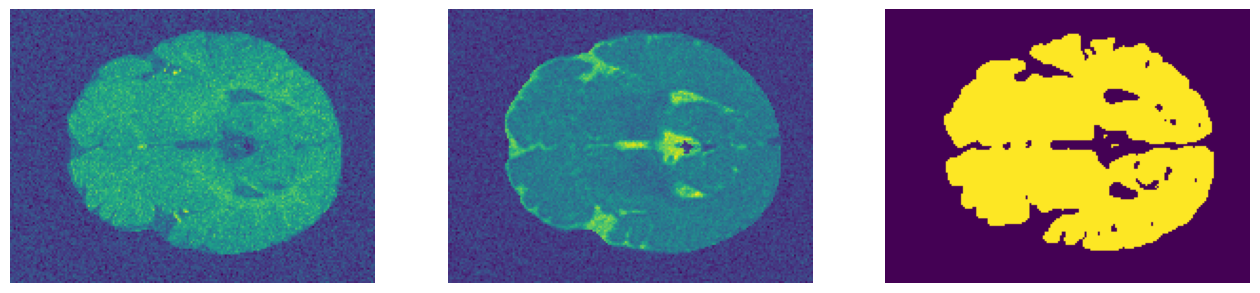

In [34]:
fast_display(input_data[0, :, :, 0], input_data[0, :, :, 1], groundtruth_2D_binarise)

### Displaying Noisy Images and Ground Truth

In this section, we are displaying three images side by side:

1. **Noisy T1 Image**: The first subplot shows the noisy T1 image, which is one of the input images that have been corrupted with Gaussian noise. This image represents a slice from the T1-weighted MRI scan.
   
2. **Noisy T2 Image**: The second subplot displays the noisy T2 image, another input image with Gaussian noise applied. This image corresponds to a slice from the T2-weighted MRI scan.

3. **Ground Truth**: The third subplot visualizes the ground truth image, which represents the actual truth (binary mask) for comparison with the predicted segmentation results.

Each image is displayed without axis labels for clarity, using `imshow` to show the images and `axis('off')` to hide the axis for a cleaner presentation. The titles of the images are set to reflect their respective content: "Noisy T1", "Noisy T2", and "Ground Truth".


(np.float64(-0.5), np.float64(191.5), np.float64(143.5), np.float64(-0.5))

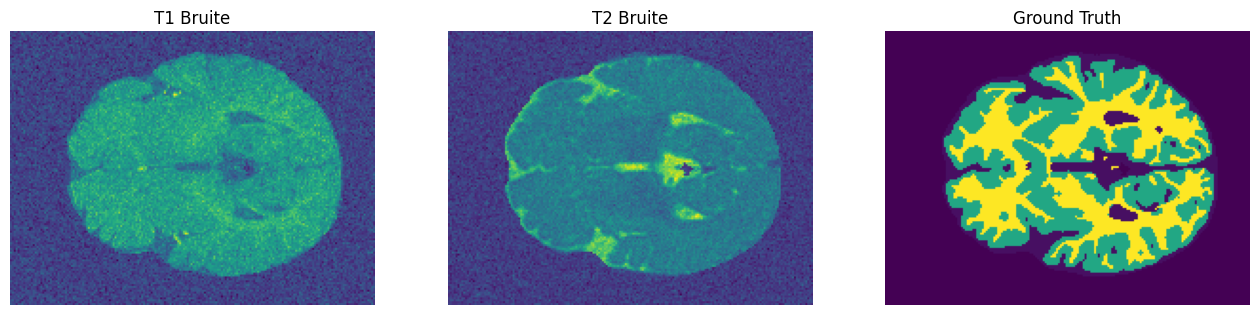

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# var_ratio_map with the MCD method
im1 = axs[0].imshow(input_data[0, :, :, 0])
axs[0].set_title("Noisy T1")
axs[0].axis('off')

# var_ratio_map with the DE method
im2 = axs[1].imshow(input_data[0, :, :, 1])
axs[1].set_title("Noisy T2")
axs[1].axis('off')

im3 = axs[2].imshow(groundtruth_2D)
axs[2].set_title(f"Ground Truth")
axs[2].axis('off')


### Monte Carlo Predictions

In this section, we are using the Monte Carlo Dropout technique to make predictions with the trained segmentation model.

- **Monte Carlo Predictions**: We perform 100 stochastic forward passes on the input data using the model (`model_segmentation_MBMG`). The `monte_carlo_predictions` function ensures that dropout is kept active during inference, which allows us to generate multiple predictions and estimate the uncertainty of the model’s output.

- **Output**: The predictions are stored in the `predictions_MCD` variable, and the shape of this array is printed to show the dimensions of the generated predictions (100 predictions per pixel).

This helps quantify uncertainty by providing a distribution of predictions for each pixel.


In [36]:
predictions_MCD = monte_carlo_predictions(model_segmentation_MBMG,input_data,n_predictions=100)
print("predictions_MCD.shape : ", predictions_MCD.shape)

predictions_MCD.shape :  (100, 120, 150)


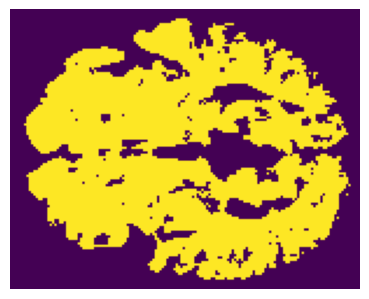

In [37]:
fast_display(np.where(np.mean(predictions_MCD,axis=0)>0.5,1,0))

In [38]:
predictions_MCD_binarise = np.where(predictions_MCD > 0.5, 1, 0)

var_ratio_map_MCD = compute_var_ratio_map(predictions_MCD_binarise)
predictive_entropy_map_MCD = compute_predictive_entropy_map(predictions_MCD)
mean_pred_MCD = np.mean(predictions_MCD,axis=0)

<class 'numpy.ndarray'>
0.013928333333333336


(np.float64(-0.5), np.float64(149.5), np.float64(119.5), np.float64(-0.5))

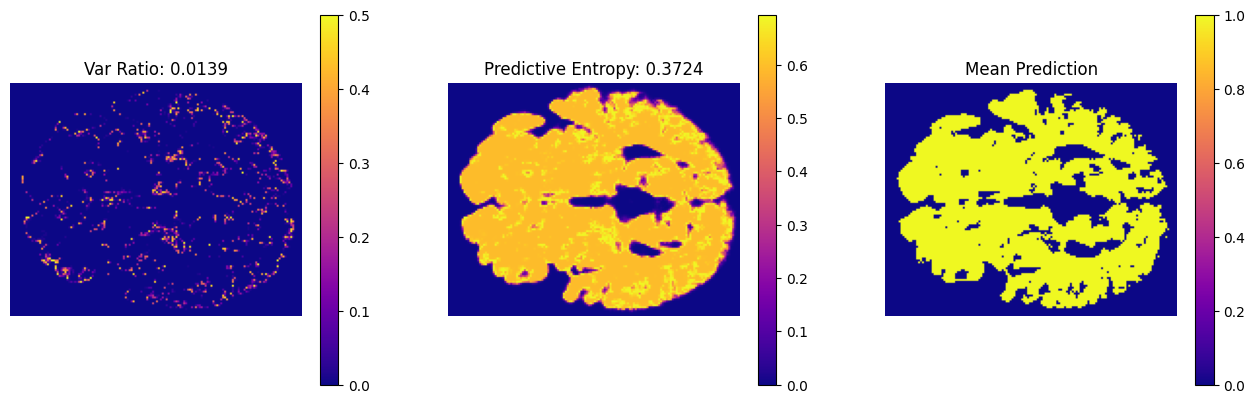

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# var_ratio_map with the MCD method
im1 = axs[0].imshow(var_ratio_map_MCD, cmap='plasma')
axs[0].set_title(f"Var Ratio: {np.mean(var_ratio_map_MCD):.4f}")
plt.colorbar(im1, ax=axs[0], shrink=0.8)
axs[0].axis('off')

# Predictive entropy map with the MCD method
im2 = axs[1].imshow(predictive_entropy_map_MCD, cmap='plasma')
axs[1].set_title(f"Predictive Entropy: {np.mean(predictive_entropy_map_MCD):.4f}")
plt.colorbar(im2, ax=axs[1], shrink=0.8)
axs[1].axis('off')

# Mean Prediction map
im3 = axs[2].imshow(np.where(mean_pred_MCD > 0.5, 1, 0), cmap='plasma')
axs[2].set_title(f"Mean Prediction")
plt.colorbar(im3, ax=axs[2], shrink=0.8)
axs[2].axis('off')


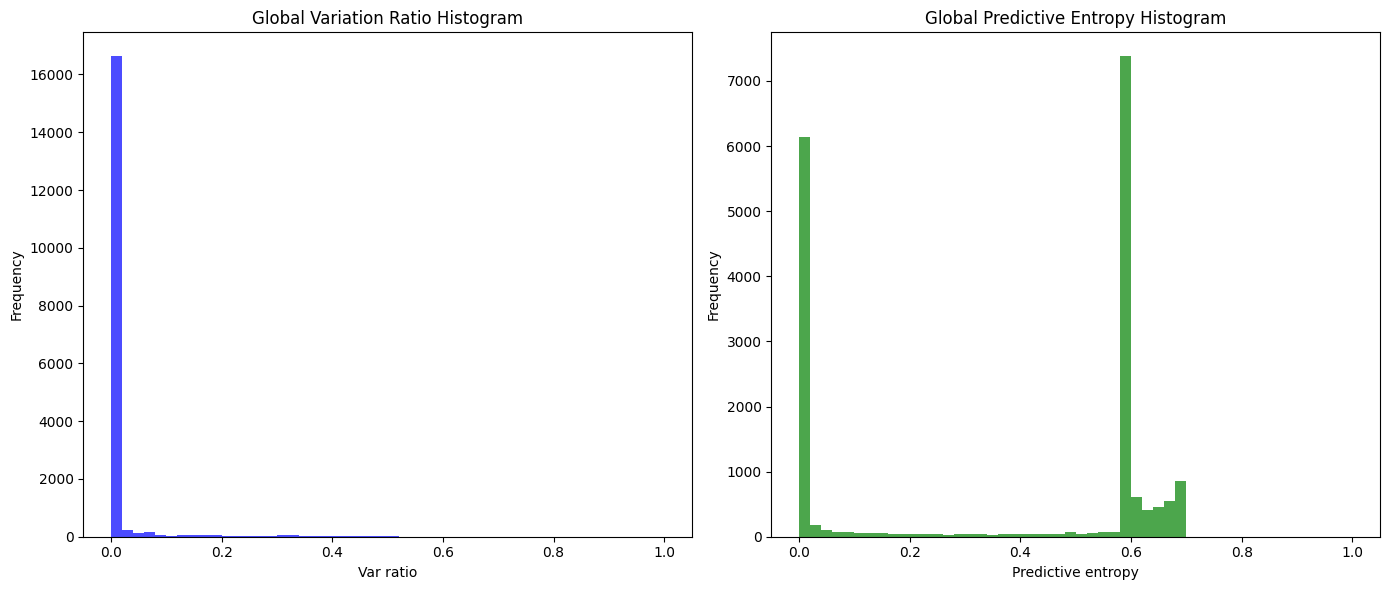

In [40]:
_ = calculate_and_plot_histograms(var_ratio_map_MCD, predictive_entropy_map_MCD)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]


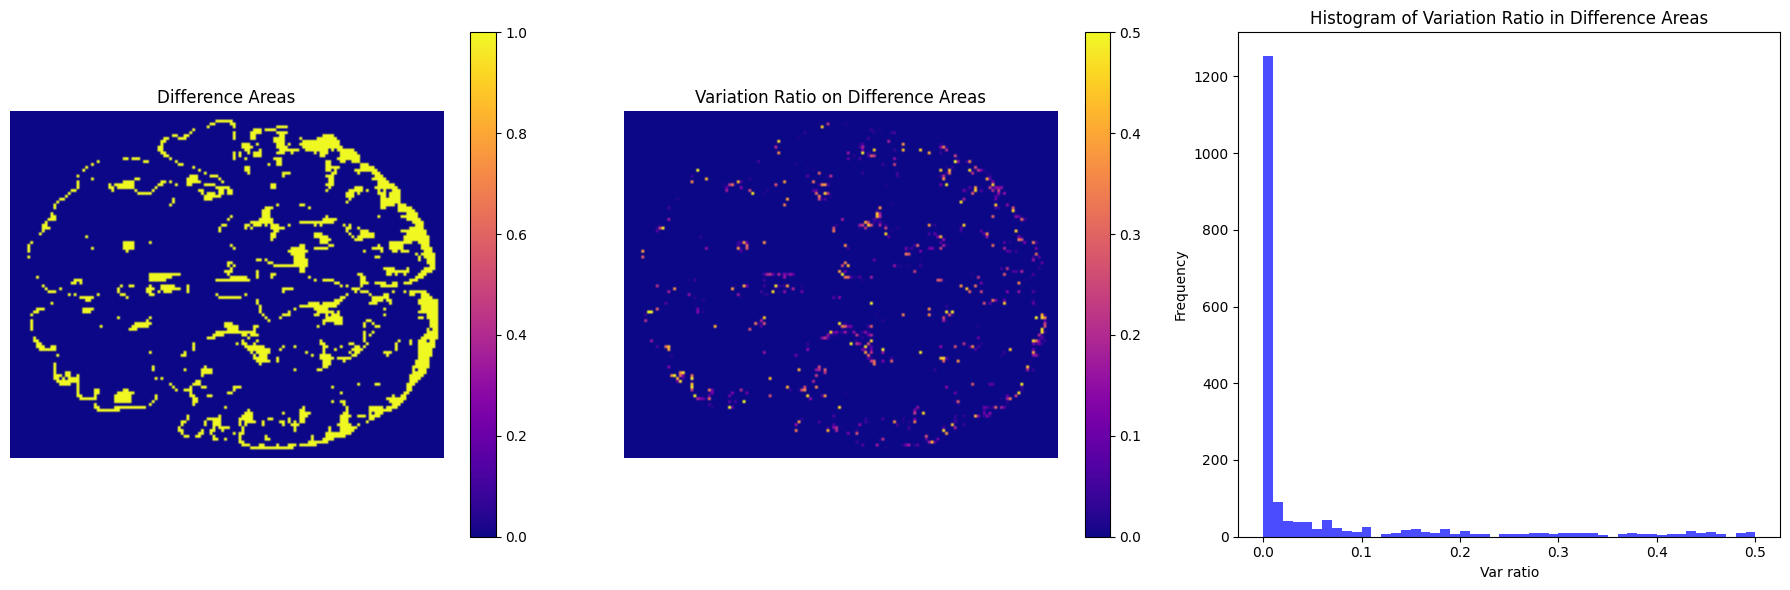

In [41]:
analyze_uncertainty_and_differences(
    predicted_segmentation=np.where(mean_pred_MCD>0.5,1,0),
    groundtruth_binarise=groundtruth_2D_binarise,
    var_ratio_map=var_ratio_map_MCD,
    predictive_entropy_map=predictive_entropy_map_MCD)

### Ensemble Predictions and Visualization

In this section, we are using an ensemble of models to make predictions on the given slice (`slice_idx`) of the input data.

- **Ensemble Predictions**: The `predire_et_visualiser_ensemble` function takes an ensemble of models (`ensembles`), applies each model to the input data (`input_data`), and generates predictions for the given slice index. The function also visualizes the individual predictions from each model in the ensemble, calculates their mean prediction, and plots the uncertainty in the form of standard deviation and histograms.

- **Output**: The `predictions_DE` variable stores the ensemble predictions, which are then used to analyze uncertainty and visualizations for the predictions.

The ensemble approach helps improve the robustness of predictions by combining the outputs of multiple models.



### Prediction with model 1/5 ###
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step

### Prediction with model 2/5 ###
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step

### Prediction with model 3/5 ###
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step

### Prediction with model 4/5 ###
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step

### Prediction with model 5/5 ###


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step

--------------------------- Displaying 5 predictions ---------------------------


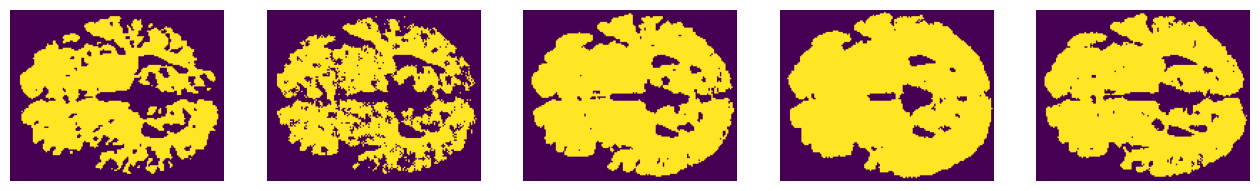

In [42]:
predictions_DE = predict_and_visualize_ensemble(ensembles, input_data, slice_index=slice_idx, ensemble_size=5)

In [43]:
predictions_DE_binarise = np.where(predictions_DE > 0.5, 1, 0)
var_ratio_map_DE = compute_var_ratio_map(predictions_DE_binarise)
predictive_entropy_map_DE = compute_predictive_entropy_map(predictions_DE)
mean_pred_DE = np.mean(predictions_DE,axis=0)
print(mean_pred_MCD.shape)

<class 'numpy.ndarray'>
0.07208888888888888
(120, 150)


(np.float64(-0.5), np.float64(149.5), np.float64(119.5), np.float64(-0.5))

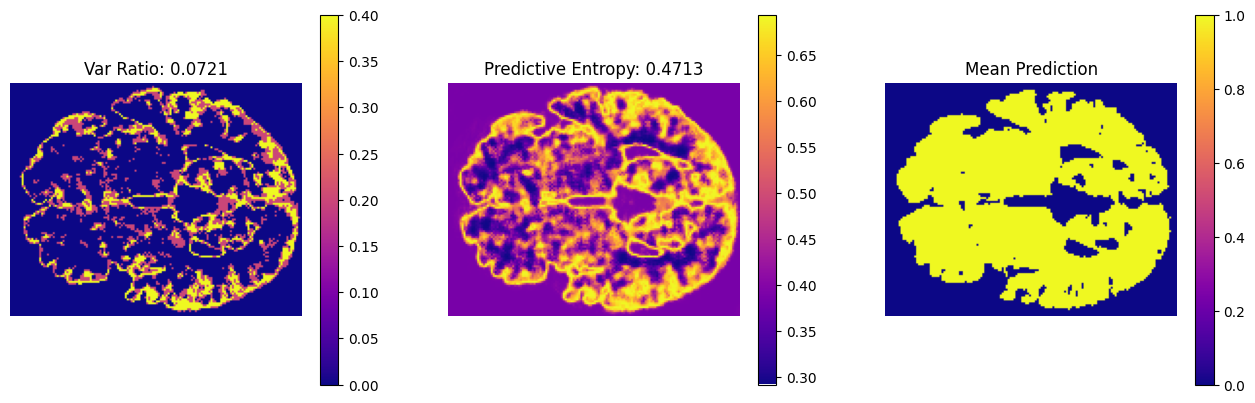

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# var_ratio_map with the DE method
im1 = axs[0].imshow(var_ratio_map_DE, cmap='plasma')
axs[0].set_title(f"Var Ratio: {np.mean(var_ratio_map_DE):.4f}")
plt.colorbar(im1, ax=axs[0], shrink=0.8)
axs[0].axis('off')

# Predictive entropy map with the DE method
im2 = axs[1].imshow(predictive_entropy_map_DE, cmap='plasma')
axs[1].set_title(f"Predictive Entropy: {np.mean(predictive_entropy_map_DE):.4f}")
plt.colorbar(im2, ax=axs[1], shrink=0.8)
axs[1].axis('off')

# Mean Prediction map
im3 = axs[2].imshow(np.where(mean_pred_DE > 0.5, 1, 0), cmap='plasma')
axs[2].set_title(f"Mean Prediction")
plt.colorbar(im3, ax=axs[2], shrink=0.8)
axs[2].axis('off')


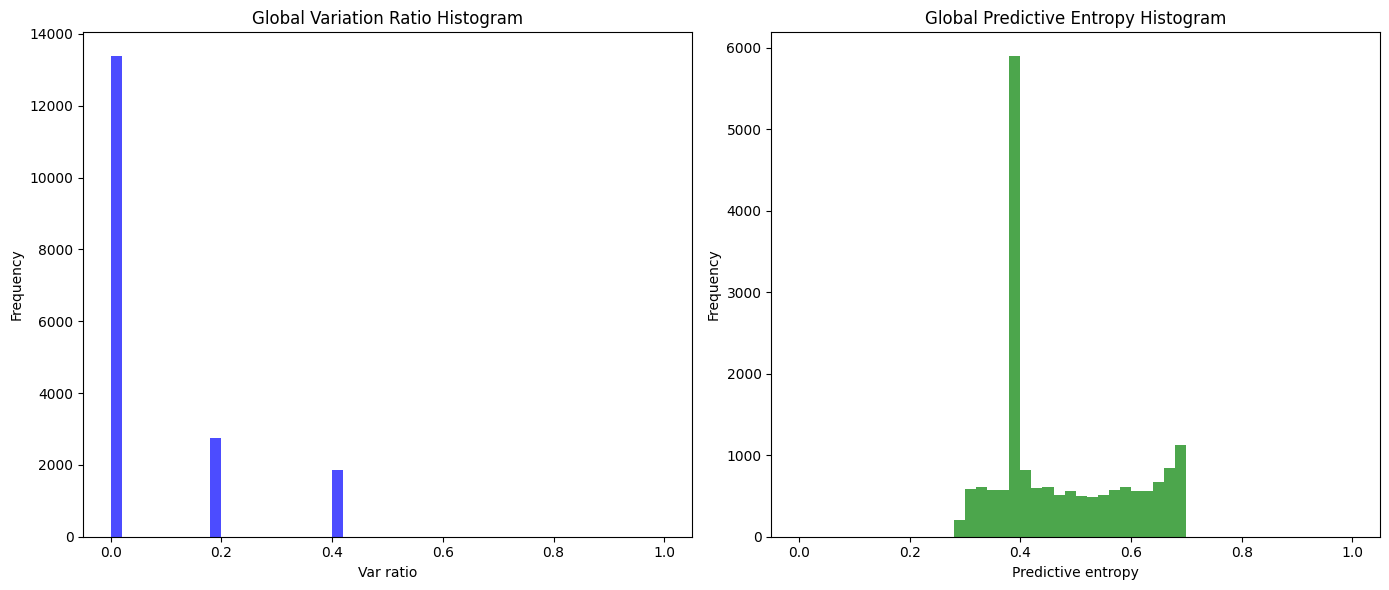

In [45]:
_ = calculate_and_plot_histograms(var_ratio_map_DE, predictive_entropy_map_DE)

[0.  0.2 0.4]


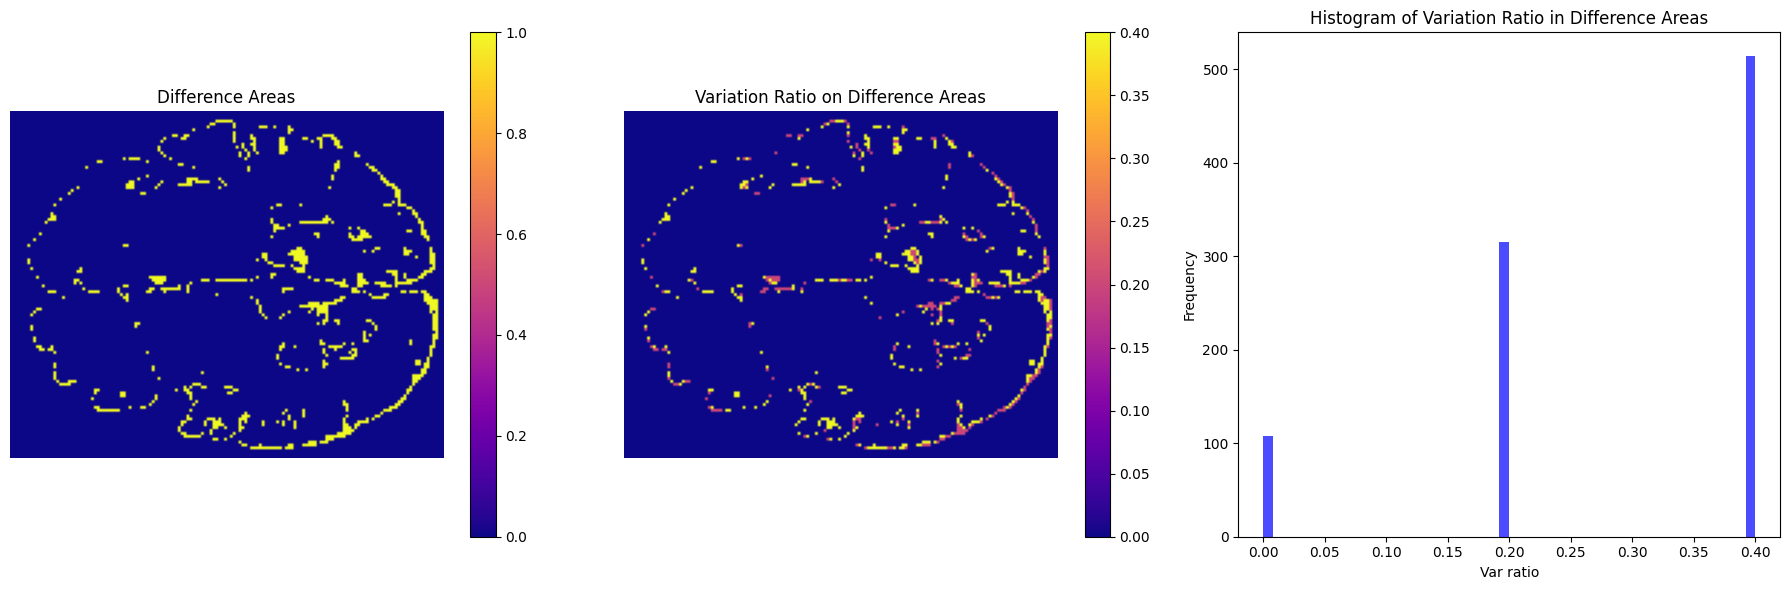

In [46]:
analyze_uncertainty_and_differences(
    predicted_segmentation=np.where(mean_pred_DE>0.5,1,0),
    groundtruth_binarise=groundtruth_2D_binarise,
    var_ratio_map=var_ratio_map_DE,
    predictive_entropy_map=predictive_entropy_map_DE
)

### Monte Carlo Dropout Combined with Deep Ensembles

In this section, we combine **Monte Carlo Dropout (MCD)** with **Deep Ensembles (DE)** to improve model uncertainty estimation.

- **Monte Carlo Dropout (MCD)**: MCD is a technique where dropout is applied not only during training but also during inference (prediction). This allows us to generate multiple stochastic predictions and estimate the model's uncertainty by observing the variability of the predictions.
  
- **Deep Ensembles (DE)**: DE involves training multiple independent models with different initializations and combining their predictions. This helps capture diverse aspects of the data, improving the robustness of predictions and providing a more reliable uncertainty estimate.

- **Combination of MCD and DE**: By combining these two techniques, we can get the benefits of both. MCD introduces stochasticity in individual models during inference, and DE introduces diversity across models. Together, they help capture both **epistemic uncertainty** (model uncertainty) and **aleatoric uncertainty** (data noise).

The result is an ensemble of models that not only gives more accurate predictions but also provides more reliable uncertainty maps, which can be visualized and analyzed for further decision-making.


In [47]:
predictions_MCD_DE = deep_ensemble_monte_carlo(ensembles,
                                               input_data)

In [48]:
predictions_MCD_DE_binarise = np.where(predictions_MCD_DE > 0.5, 1, 0)
var_ratio_map_MCD_DE = compute_var_ratio_map(predictions_MCD_DE_binarise)
predictive_entropy_map_MCD_DE = compute_predictive_entropy_map(predictions_MCD_DE)
mean_pred_MCD_DE = np.mean(predictions_MCD_DE,axis=0)
print(mean_pred_MCD_DE.shape)

<class 'numpy.ndarray'>
0.06433166666666668
(120, 150)


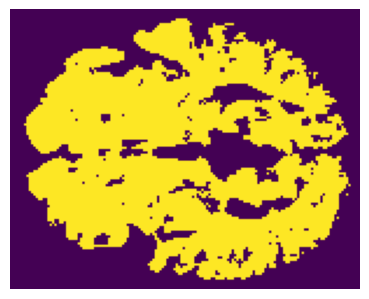

In [49]:
fast_display(np.where(mean_pred_MCD>0.5,1,0))

(np.float64(-0.5), np.float64(149.5), np.float64(119.5), np.float64(-0.5))

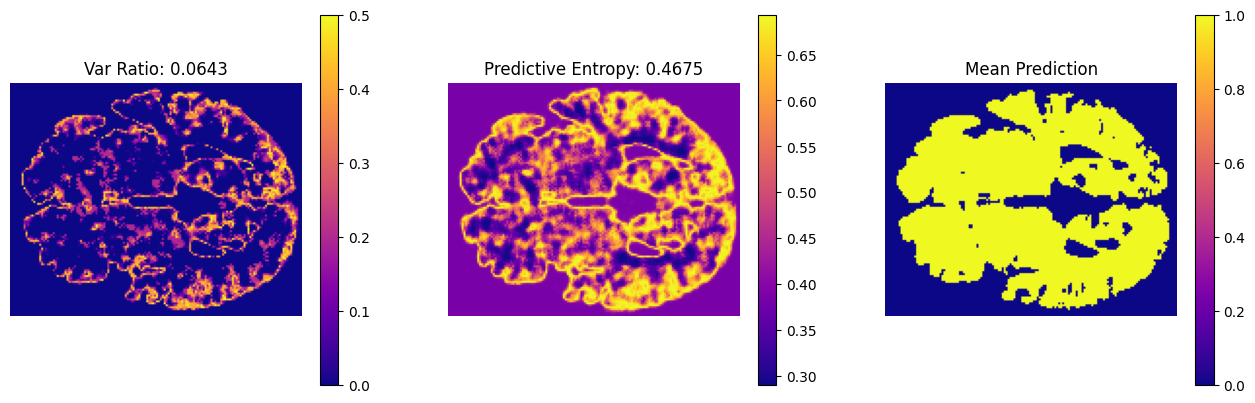

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# var_ratio_map with the combined MCD and DE method
im1 = axs[0].imshow(var_ratio_map_MCD_DE, cmap='plasma')
axs[0].set_title(f"Var Ratio: {np.mean(var_ratio_map_MCD_DE):.4f}")
plt.colorbar(im1, ax=axs[0], shrink=0.8)
axs[0].axis('off')

# Predictive entropy map with the combined MCD and DE method
im2 = axs[1].imshow(predictive_entropy_map_MCD_DE, cmap='plasma')
axs[1].set_title(f"Predictive Entropy: {np.mean(predictive_entropy_map_MCD_DE):.4f}")
plt.colorbar(im2, ax=axs[1], shrink=0.8)
axs[1].axis('off')

# Mean Prediction map
im3 = axs[2].imshow(np.where(mean_pred_MCD_DE > 0.5, 1, 0), cmap='plasma')
axs[2].set_title(f"Mean Prediction")
plt.colorbar(im3, ax=axs[2], shrink=0.8)
axs[2].axis('off')

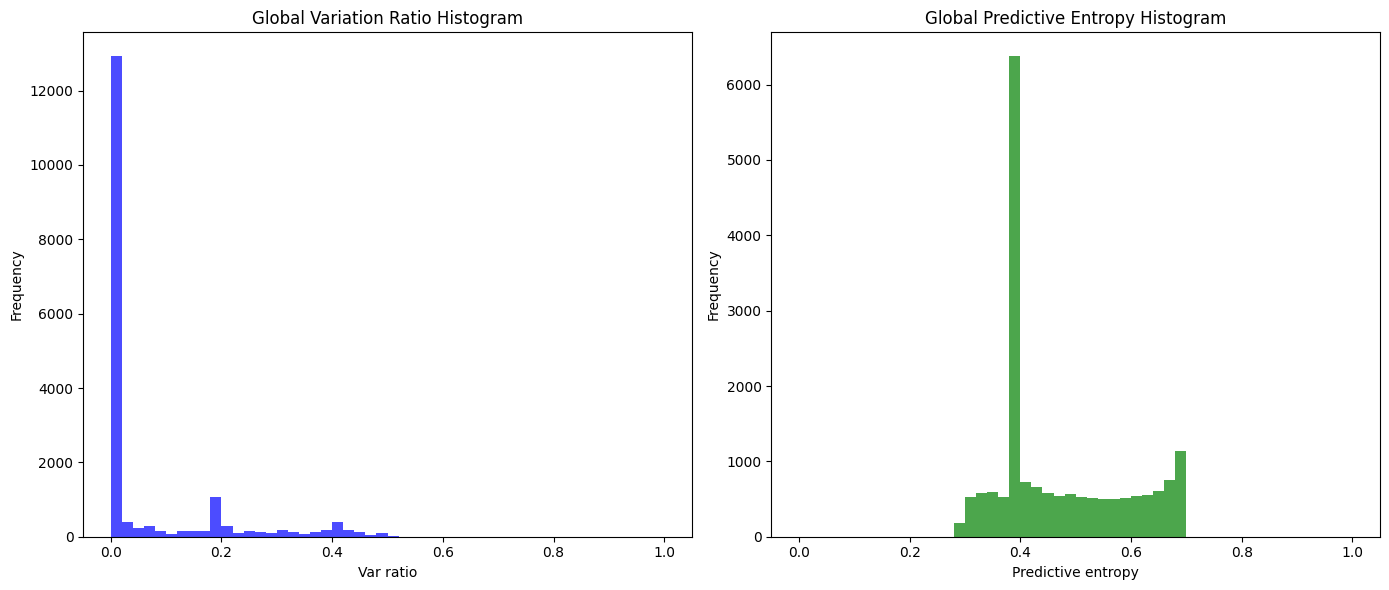

In [51]:
_ = calculate_and_plot_histograms(var_ratio_map_MCD_DE, predictive_entropy_map_MCD_DE)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]


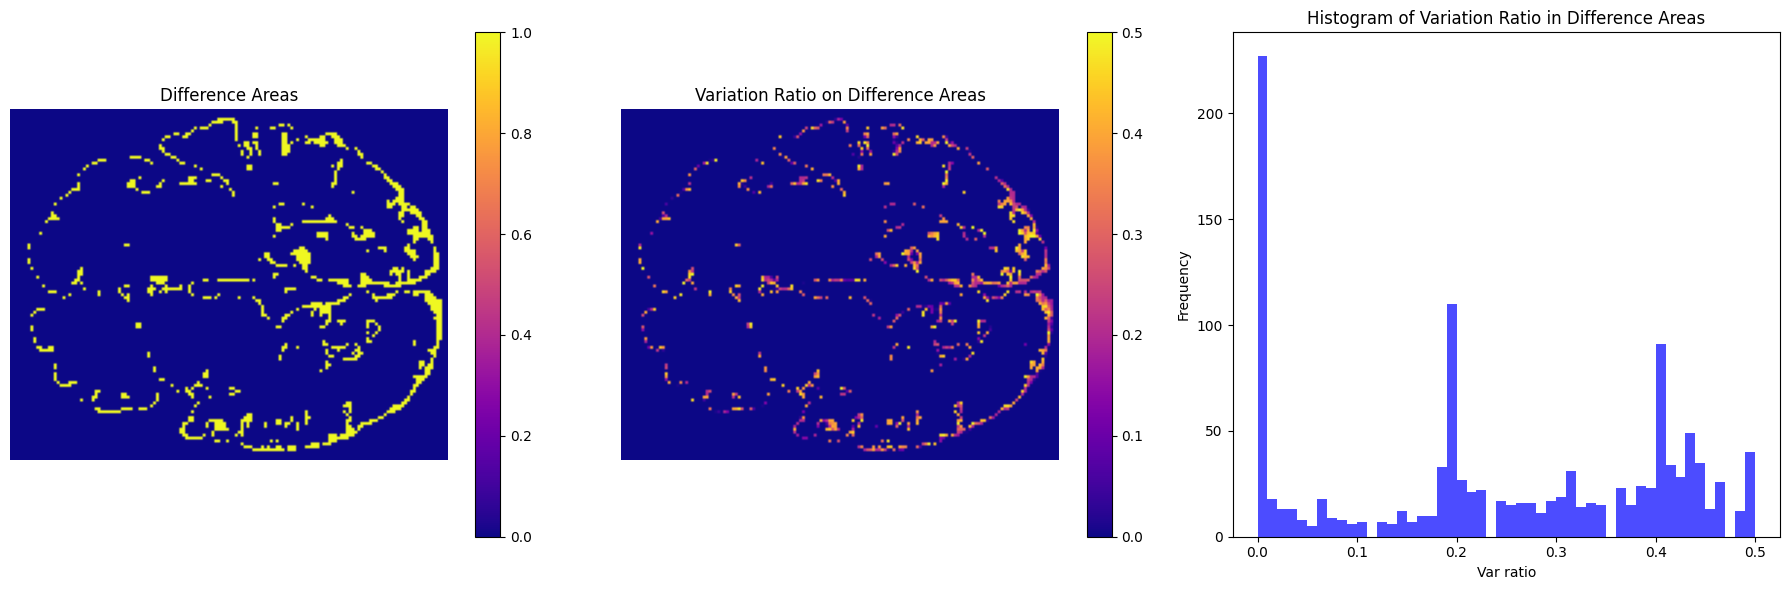

In [52]:
analyze_uncertainty_and_differences(
    predicted_segmentation=np.where(mean_pred_MCD_DE>0.5,1,0),
    groundtruth_binarise=groundtruth_2D_binarise,
    var_ratio_map=var_ratio_map_MCD_DE,
    predictive_entropy_map=predictive_entropy_map_MCD_DE
)

Text(0.5, 1.0, 'Histogram (DE)')

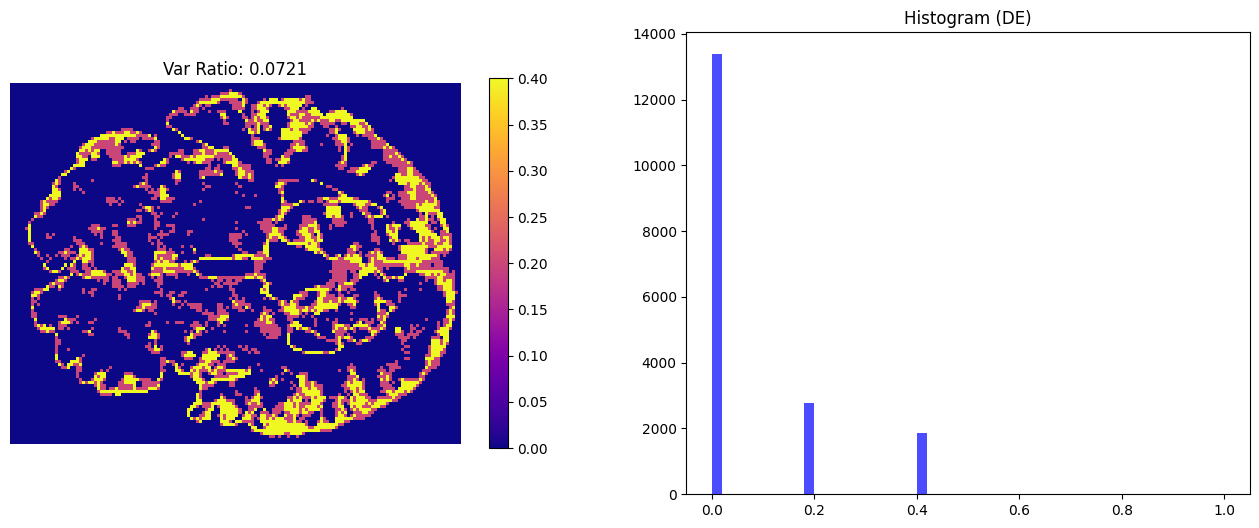

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# var_ratio_map with the DE method
im1 = axs[0].imshow(var_ratio_map_DE, cmap='plasma')
axs[0].set_title(f"Var Ratio: {np.mean(var_ratio_map_DE):.4f}")
plt.colorbar(im1, ax=axs[0], shrink=0.8)
axs[0].axis('off')

# Histogram for the DE method
axs[1].hist(var_ratio_map_DE.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
axs[1].set_title("Histogram (DE)")

Text(0.5, 1.0, 'Histogram (DE)')

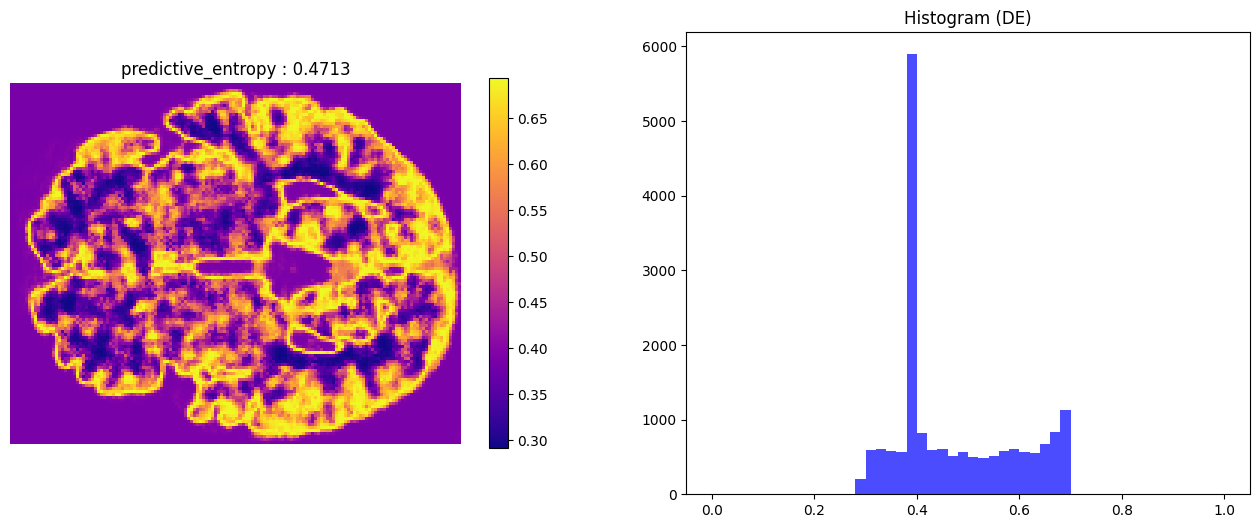

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# var_ratio_map with the DE method
im1 = axs[0].imshow(predictive_entropy_map_DE, cmap='plasma')
axs[0].set_title(f"predictive_entropy : {np.mean(predictive_entropy_map_DE):.4f}")
plt.colorbar(im1, ax=axs[0], shrink=0.8)
axs[0].axis('off')

# Histogram for the DE method
axs[1].hist(predictive_entropy_map_DE.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
axs[1].set_title("Histogram (DE)")

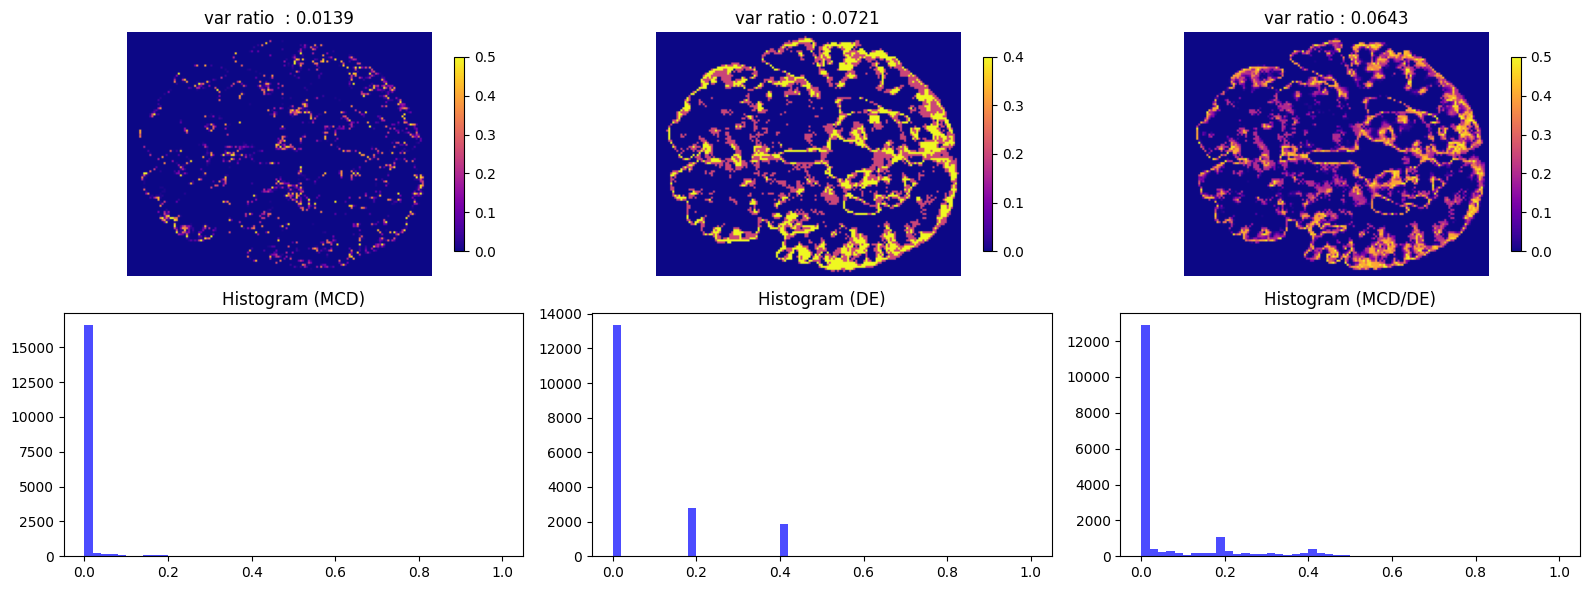

In [56]:
fig, axs = plt.subplots(2, 3, figsize=(16, 6))

# var_ratio_map with the MCD method
im1 = axs[0][0].imshow(var_ratio_map_MCD, cmap='plasma')
axs[0][0].set_title(f"var ratio  : {np.mean(var_ratio_map_MCD):.4f}")
plt.colorbar(im1, ax=axs[0][0], shrink=0.8)
axs[0][0].axis('off')

# var_ratio_map with the DE method
im2 = axs[0][1].imshow(var_ratio_map_DE, cmap='plasma')
axs[0][1].set_title(f"var ratio : {np.mean(var_ratio_map_DE):.4f}")
plt.colorbar(im2, ax=axs[0][1], shrink=0.8)
axs[0][1].axis('off')

# var_ratio_map with the MCD/DE hybrid method
im3 = axs[0][2].imshow(var_ratio_map_MCD_DE, cmap='plasma')
axs[0][2].set_title(f"var ratio : {np.mean(var_ratio_map_MCD_DE):.4f}")
plt.colorbar(im3, ax=axs[0][2], shrink=0.8)
axs[0][2].axis('off')

# Histogram for the MCD method
axs[1][0].hist(var_ratio_map_MCD.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
axs[1][0].set_title("Histogram (MCD)")

# Histogram for the DE method
axs[1][1].hist(var_ratio_map_DE.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
axs[1][1].set_title("Histogram (DE)")

# Histogram for the MCD/DE method
axs[1][2].hist(var_ratio_map_MCD_DE.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
axs[1][2].set_title("Histogram (MCD/DE)")

plt.tight_layout()
plt.show()


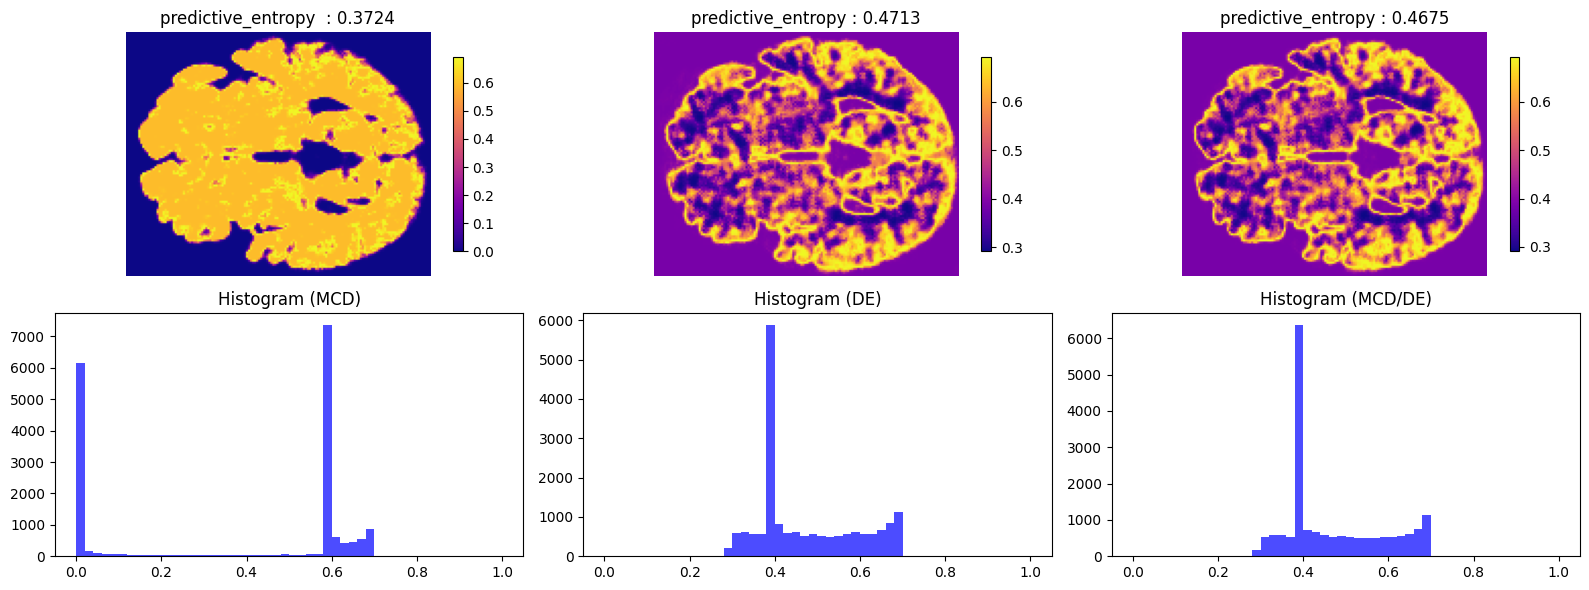

In [57]:
fig, axs = plt.subplots(2, 3, figsize=(16, 6))

# predictive_entropy_map with the MCD method
im1 = axs[0][0].imshow(predictive_entropy_map_MCD, cmap='plasma')
axs[0][0].set_title(f"predictive_entropy  : {np.mean(predictive_entropy_map_MCD):.4f}")
plt.colorbar(im1, ax=axs[0][0], shrink=0.8)
axs[0][0].axis('off')

# predictive_entropy_map with the DE method
im2 = axs[0][1].imshow(predictive_entropy_map_DE, cmap='plasma')
axs[0][1].set_title(f"predictive_entropy : {np.mean(predictive_entropy_map_DE):.4f}")
plt.colorbar(im2, ax=axs[0][1], shrink=0.8)
axs[0][1].axis('off')

# predictive_entropy_map with the MCD/DE hybrid method
im3 = axs[0][2].imshow(predictive_entropy_map_MCD_DE, cmap='plasma')
axs[0][2].set_title(f"predictive_entropy : {np.mean(predictive_entropy_map_MCD_DE):.4f}")
plt.colorbar(im3, ax=axs[0][2], shrink=0.8)
axs[0][2].axis('off')

# Histogram for the MCD method
axs[1][0].hist(predictive_entropy_map_MCD.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
axs[1][0].set_title("Histogram (MCD)")

# Histogram for the DE method
axs[1][1].hist(predictive_entropy_map_DE.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
axs[1][1].set_title("Histogram (DE)")

# Histogram for the MCD/DE method
axs[1][2].hist(predictive_entropy_map_MCD_DE.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
axs[1][2].set_title("Histogram (MCD/DE)")

plt.tight_layout()
plt.show()
